# $\nu$ from flux pdf:


## Flux pdf comparison :

Checking the quality of the mock maps by comparing the flux pdf to that in LATIS.

In [1]:
#import spectra_mocking as sm
import h5py
import numpy as np
import matplotlib.pyplot as plt
import importlib
from scipy.ndimage.filters import gaussian_filter
plt.style.use('paper.mystyle')

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import importlib
from scipy.ndimage.filters import gaussian_filter
plt.style.use('paper.mystyle')

def write_flat_spectra():
    """Write down a spectra with tau = - ln(mean flux). It is used in next method to generate 
    pure noise maps """
    from LATIS.codes import spectra_mocking as sm
    fs = h5py.File('./spectra/spectra_TNG_z2.4_1.hdf5','r')
    print()
    fw = h5py.File('./spectra/spectra_flat.hdf5','w')
    mean_flux_desired = sm.get_mean_flux(z=fs['Header'].attrs['redshift'])
    fw['tau/H/1/1215'] = -np.log(mean_flux_desired)*np.ones_like(fs['tau/H/1/1215'])
    
    fw.create_group('spectra')
    fw['spectra/axis'] = fs['spectra/axis'][:]
    fw['spectra/cofm'] = fs['spectra/cofm'][:]
    fw['colden/H/1'] = np.zeros(shape=(1,))
    for k in fs.keys():
        if k in ['tau','colden','spectra']:
            continue
        fw.create_group(k)
    for k in fs['Header'].attrs.keys():
        fw['Header'].attrs.create(k, fs['Header'].attrs[k])
    fw.close()

def write_input_dashcund():
    """Write a pixel file for this flat spectra. The file will be read by dachshund to generate
    a pure noise map"""
    from LATIS.codes import spectra_mocking as sm
    importlib.reload(sm)
    with h5py.File('./spectra/spectra_flat.hdf5','r') as f:
        z=f['Header'].attrs['redshift']
    _, spec_res = sm.get_spec_res(z=z)
    sm.write_input_dachshund_v2(spec_res=spec_res, savefile='./spectra/spectra_flat.hdf5', output_file='./spectra/pix_purenoise_z2.4.dat',
                               domask=False)
    
def compare_with_pure_noise(z=2.4, NoiseMap='wiener filtered'):
    """This compares the flux pdf in mock, pure noise and LATIS maps"""
    import LATIS.codes.spectra_mocking as sm
    from scipy.ndimage import gaussian_filter as gf
    importlib.reload(sm)
    plt.style.use('paper.mystyle')
    
    for over_sigma in [True]:
        fig, ax = plt.subplots(1,3,figsize=(35,11))
        fig1, ax1 = plt.subplots(1,3,figsize=(30,10))
        
        sm.plot_flux_pdf_v3(ax=[[ax[0],ax[1],ax[2]],[ax1[0],ax1[1],ax1[2]]] ,lratio=2, z_range=[2.2,2.8], 
                            filename='./spectra/maps/map_TNG_z'+str(z)+'_n1.dat', label='Mocks', over_sigma=over_sigma)        
        
        for i, sigma in enumerate([1,2,4]):
            if NoiseMap=='wiener filtered':
                PureNoise = np.fromfile('./spectra/maps/map_purenoise_z'+str(z)+'.dat').reshape((205,205,205))
                PureNoise = gf(PureNoise, sigma=sigma, mode='wrap')
            else:
                PureNoise, StdMock, StdNoiseless = compute_pure_noise_map(sigma=sigma)

            StdLatis = np.std(sm.get_latis_map(sigma=sigma))
            #print('std in PureNoise :', np.std(PureNoise), ' std in mock ', StdMock,
            #      ' std in noiselss', StdNoiseless, 'std LATIS', StdLatis)
            if over_sigma:
                bins = np.arange(-6,5,0.2)
                ax[i].hist(np.ravel(PureNoise/StdLatis), bins=bins, density=True, histtype='step',
                             label='Pure Noise', color='C0')
                ax1[i].hist(np.ravel(PureNoise/StdLatis), bins=bins, density=True, histtype='step',
                             label=NoiseMap, color='C0')
            else:
                bins = np.arange(-.2,.2, 0.01)
                ax[i].hist(np.ravel(PureNoise/StdLatis), bins=bins, density=True, histtype='step',
                            label='Noise '+NoiseMap)
                ax1[i].hist(np.ravel(PureNoise/StdLatis), bins=bins, density=True, histtype='step',
                            label='Noise '+NoiseMap)
                ax[2].set_xlim((-.3,.3))
                ax1[2].set_xlim((-.3,.3))

            for i in range(3):
                ax[i].set_ylim((1e-6,1))
            ax[0].legend(loc='upper left')

        fig.tight_layout()
        #fig.savefig('./flux_pdf_all_LATIS.pdf')


LATIS mean deltaF  at z=[2.2, 2.8] is  0.0014317872940299533
LATIS mean deltaF  at z=[2.2, 2.8] is  0.0013913208566972387
LATIS mean deltaF  at z=[2.2, 2.8] is  0.0013314368584052604


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


LATIS mean deltaF  at z=[2.2, 2.8] is  0.0014317872940299533
LATIS mean deltaF  at z=[2.2, 2.8] is  0.0013913208566972387
LATIS mean deltaF  at z=[2.2, 2.8] is  0.0013314368584052604


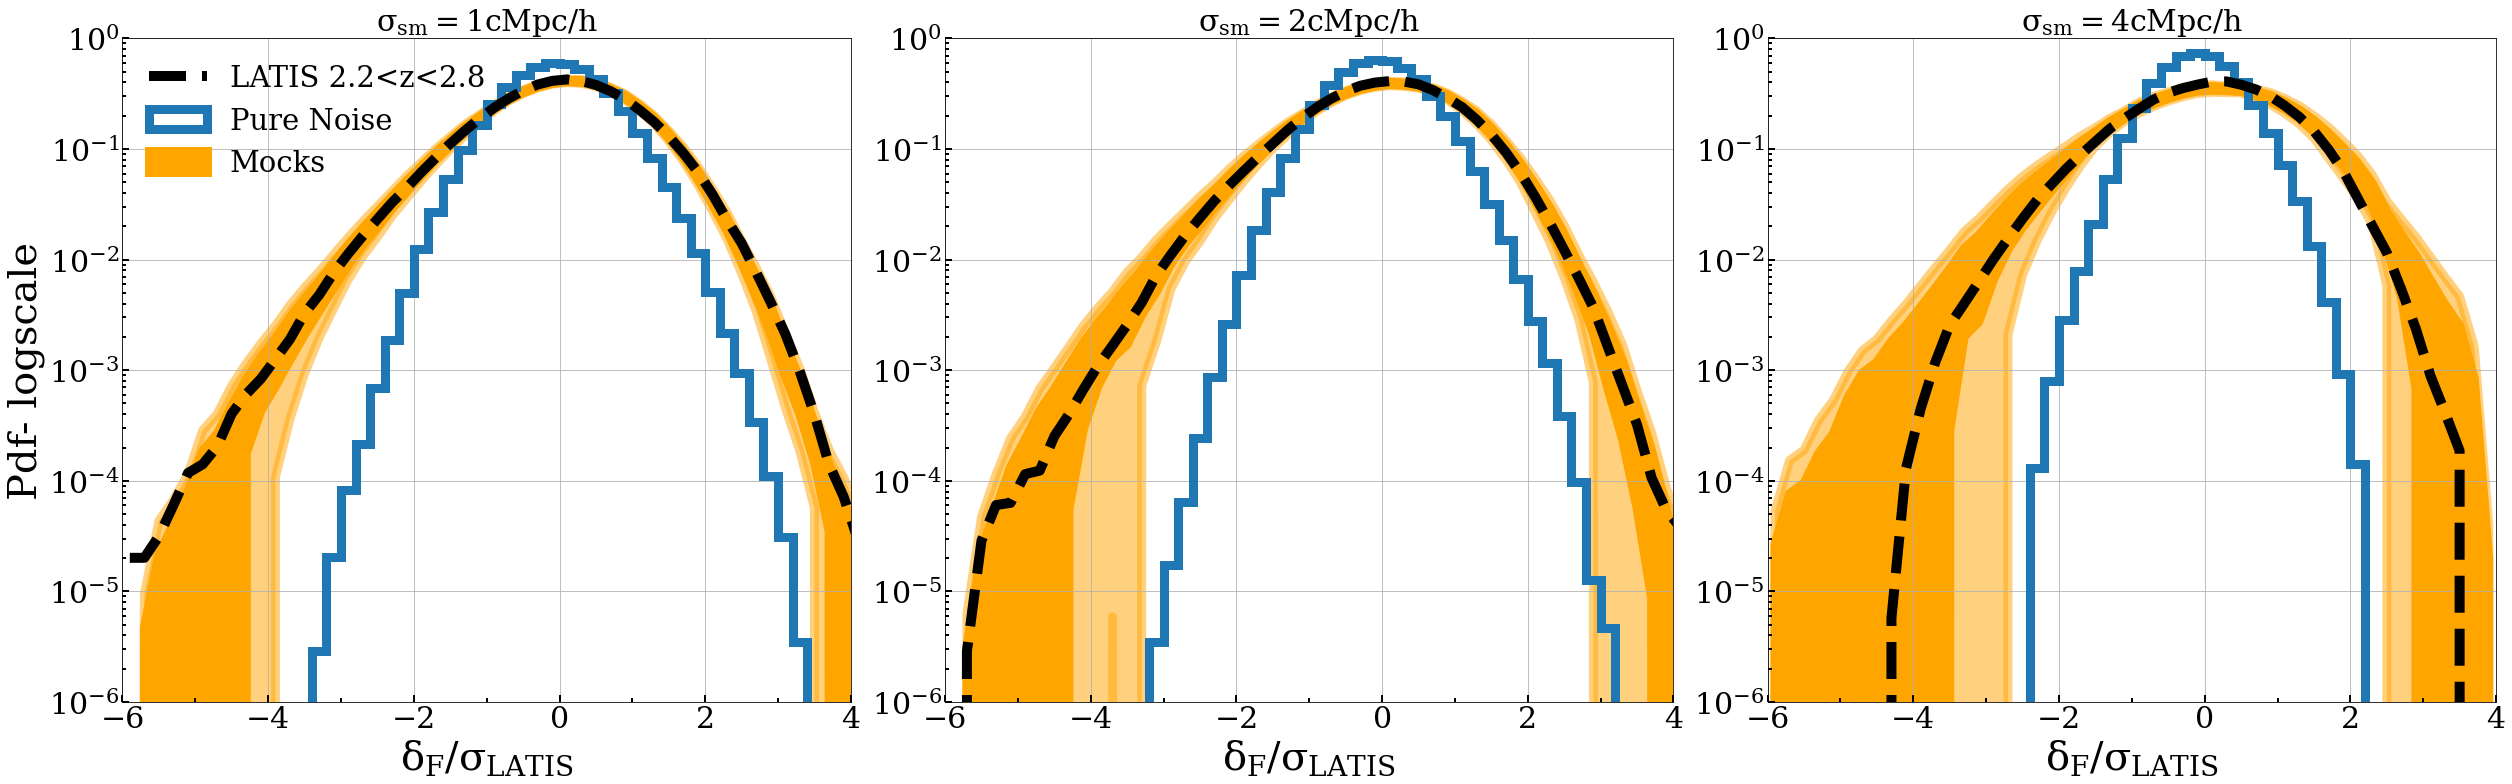

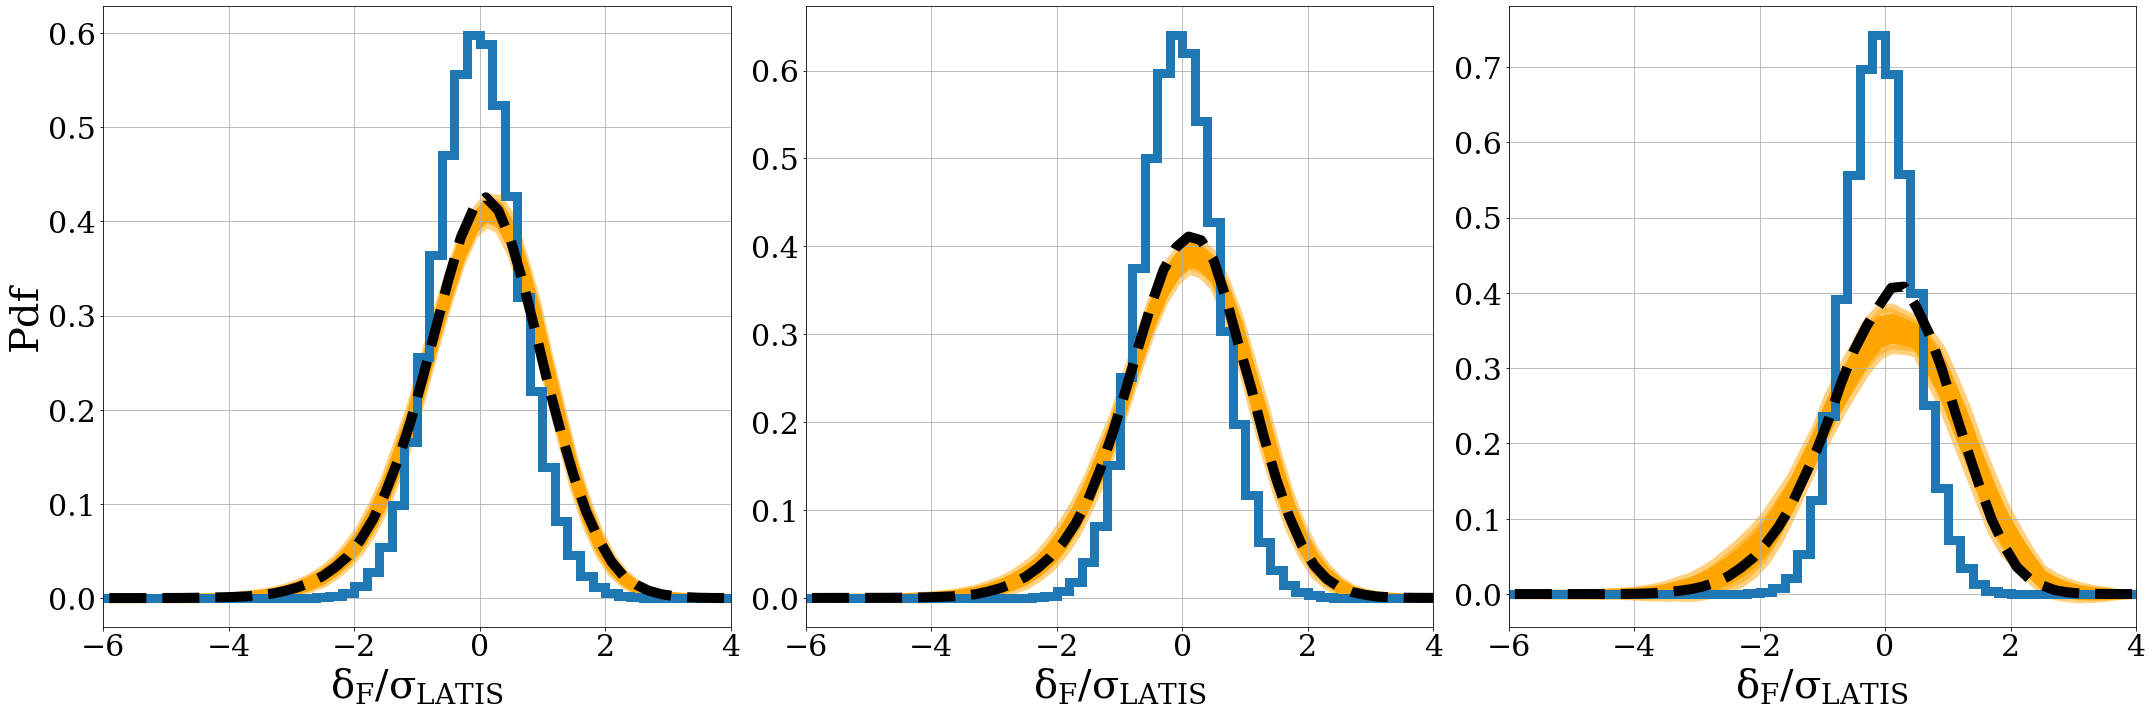

In [2]:
compare_with_pure_noise()

## Select $\nu$ :

In [20]:
def get_ratio_hists(z=2.4, z_range=[2.4,2.6], sigma=[1,2,4], bins = np.arange(-6,5,0.05)):
    import LATIS.codes.spectra_mocking as sm
    from scipy.ndimage import gaussian_filter as gf
    for i in range(3):
        mL = sm.get_latis_map(latis_file='./spectra/maps/mapsv13/dcv13map.dat', map_version=13, z_range=z_range, sigma=sigma[i])
        mL = np.ravel(mL)
        histl = np.histogram(np.ravel(mL/(np.std(mL))), bins=bins, density=True)[0]

        PureNoise = np.fromfile('./spectra/maps/map_purenoise_z'+str(z)+'.dat').reshape((205,205,205))
        PureNoise = gf(PureNoise, sigma=sigma[i], mode='wrap')
        histn = np.histogram(np.ravel(PureNoise/(np.std(mL))), bins=bins, density=True)[0]
        
        mbins = np.array([(bins[i]+bins[i+1])/2 for i in range(bins.size-1)])
        ind0 = np.where(histn!=0)[0]
        ratio = histl[ind0]/histn[ind0]
        plt.plot(mbins[ind0], ratio, label='$\sigma$ ='+str(sigma[i]))
        plt.ylim((0,150))
        ind1 = (ratio > 80)*(mbins[ind0] < 0)
        plt.legend()
        print('Sigma = ', sigma[i],' ratio = ',ratio[ind1] ,' at :', mbins[ind0][ind1])

LATIS mean deltaF  at z=[2.4, 2.6] is  -0.006267227250374733
Sigma =  1  ratio =  [1156.71486295 3695.66761244  840.98262992  586.15200602  721.25796486
  632.11112706  422.85566924  318.19938532  192.26617219  183.69214019
  208.03221943  142.05270247  123.4340831    82.51437754   80.89729104]  at : [-3.175 -3.075 -3.025 -2.975 -2.925 -2.875 -2.825 -2.775 -2.725 -2.675
 -2.625 -2.575 -2.525 -2.475 -2.425]
LATIS mean deltaF  at z=[2.4, 2.6] is  -0.006173286480125419
Sigma =  2  ratio =  [4990.60626404 1993.33253112 1571.38622891 2415.27883332 1256.13899163
  904.73752574  634.73818737  658.78589329  399.36891386  282.9141873
  278.15932701  200.32690294  162.79385635  101.7664377 ]  at : [-2.925 -2.875 -2.825 -2.775 -2.725 -2.675 -2.625 -2.575 -2.525 -2.475
 -2.425 -2.375 -2.325 -2.275]
LATIS mean deltaF  at z=[2.4, 2.6] is  -0.006028455583276911
Sigma =  4  ratio =  [1964.23278614  586.94804768  509.7305329   299.5714818   229.77817498
  137.90748708   86.84276835]  at : [-2.175 -2.12

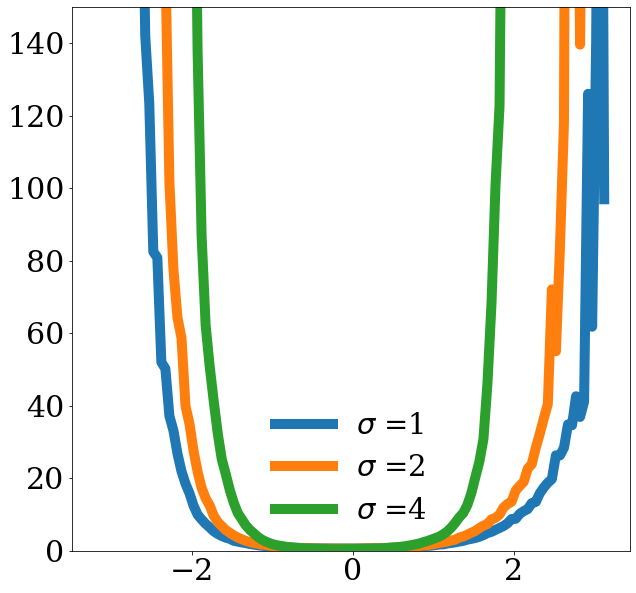

In [21]:
get_ratio_hists()

## Other Redhsifts :

LATIS mean deltaF  at z=[2.2, 2.4] is  0.002944165263101341
LATIS mean deltaF  at z=[2.2, 2.4] is  0.003012623935547442
LATIS mean deltaF  at z=[2.2, 2.4] is  0.0029782073338613297
LATIS mean deltaF  at z=[2.2, 2.8] is  0.0014317872940299533
LATIS mean deltaF  at z=[2.2, 2.8] is  0.0013913208566972387
LATIS mean deltaF  at z=[2.2, 2.8] is  0.0013314368584052604


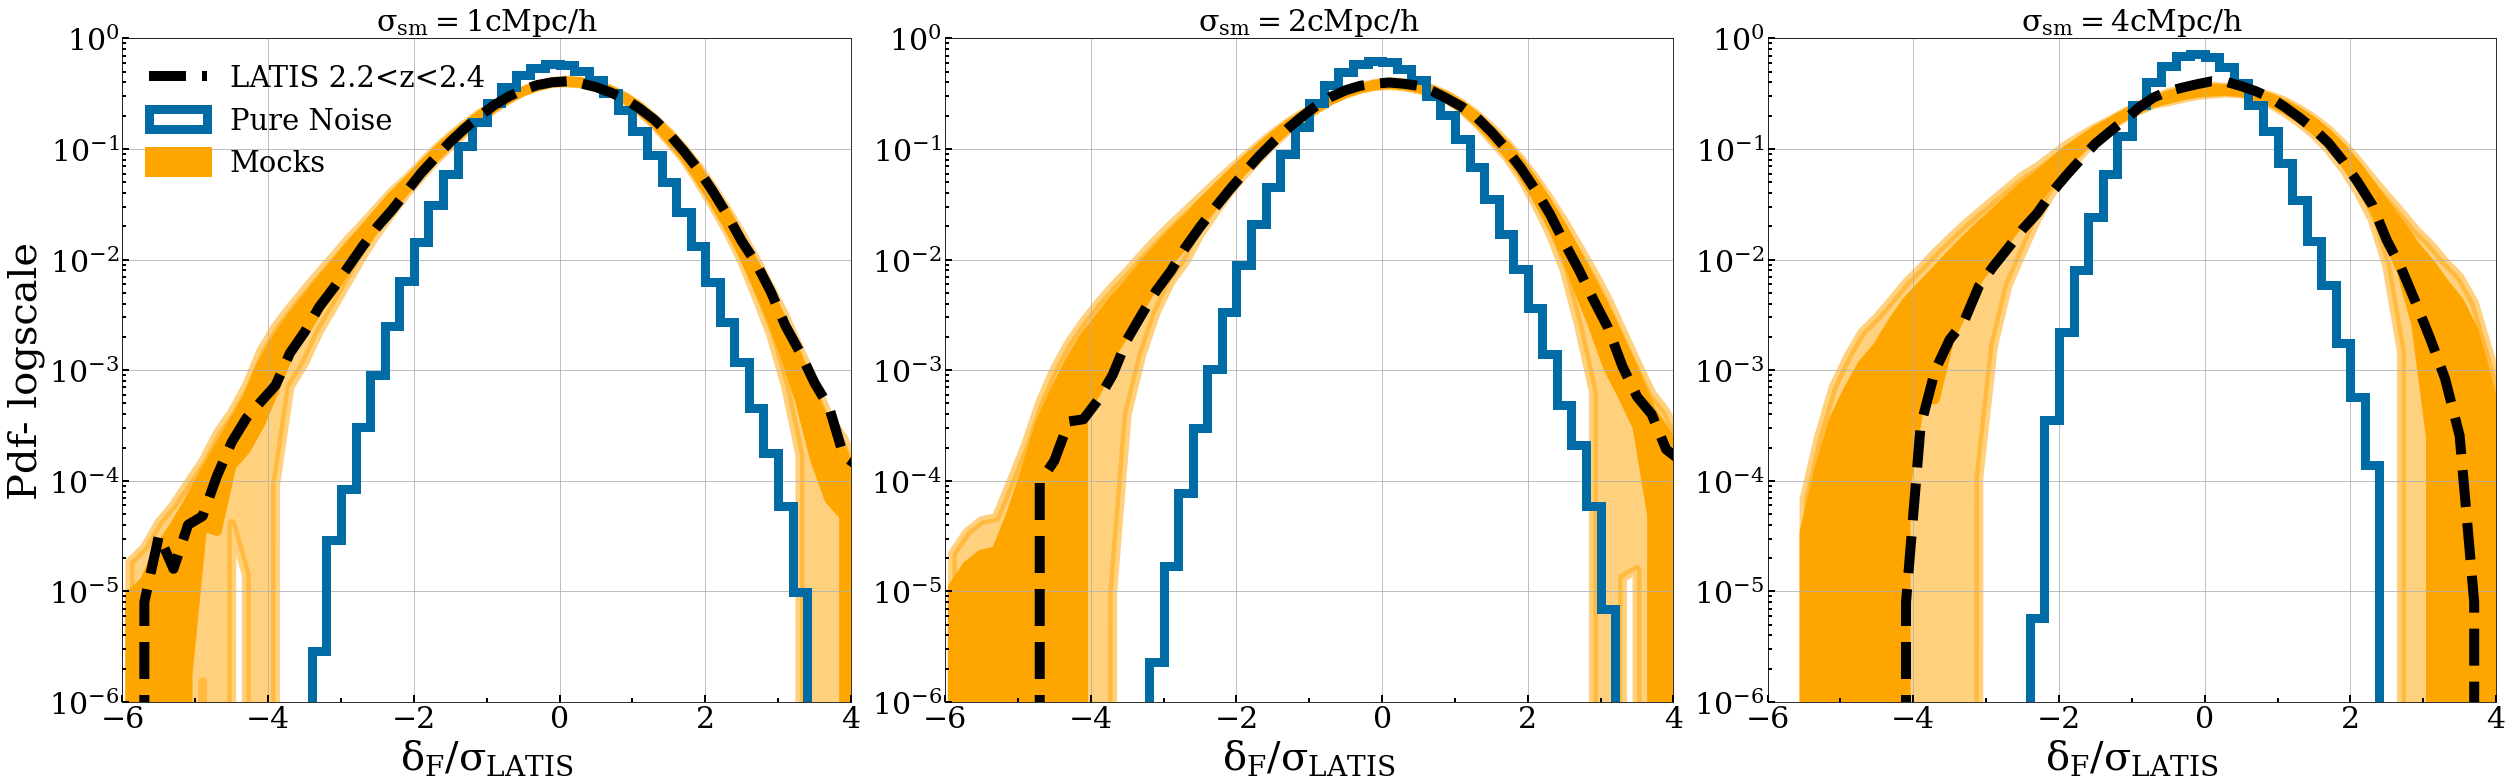

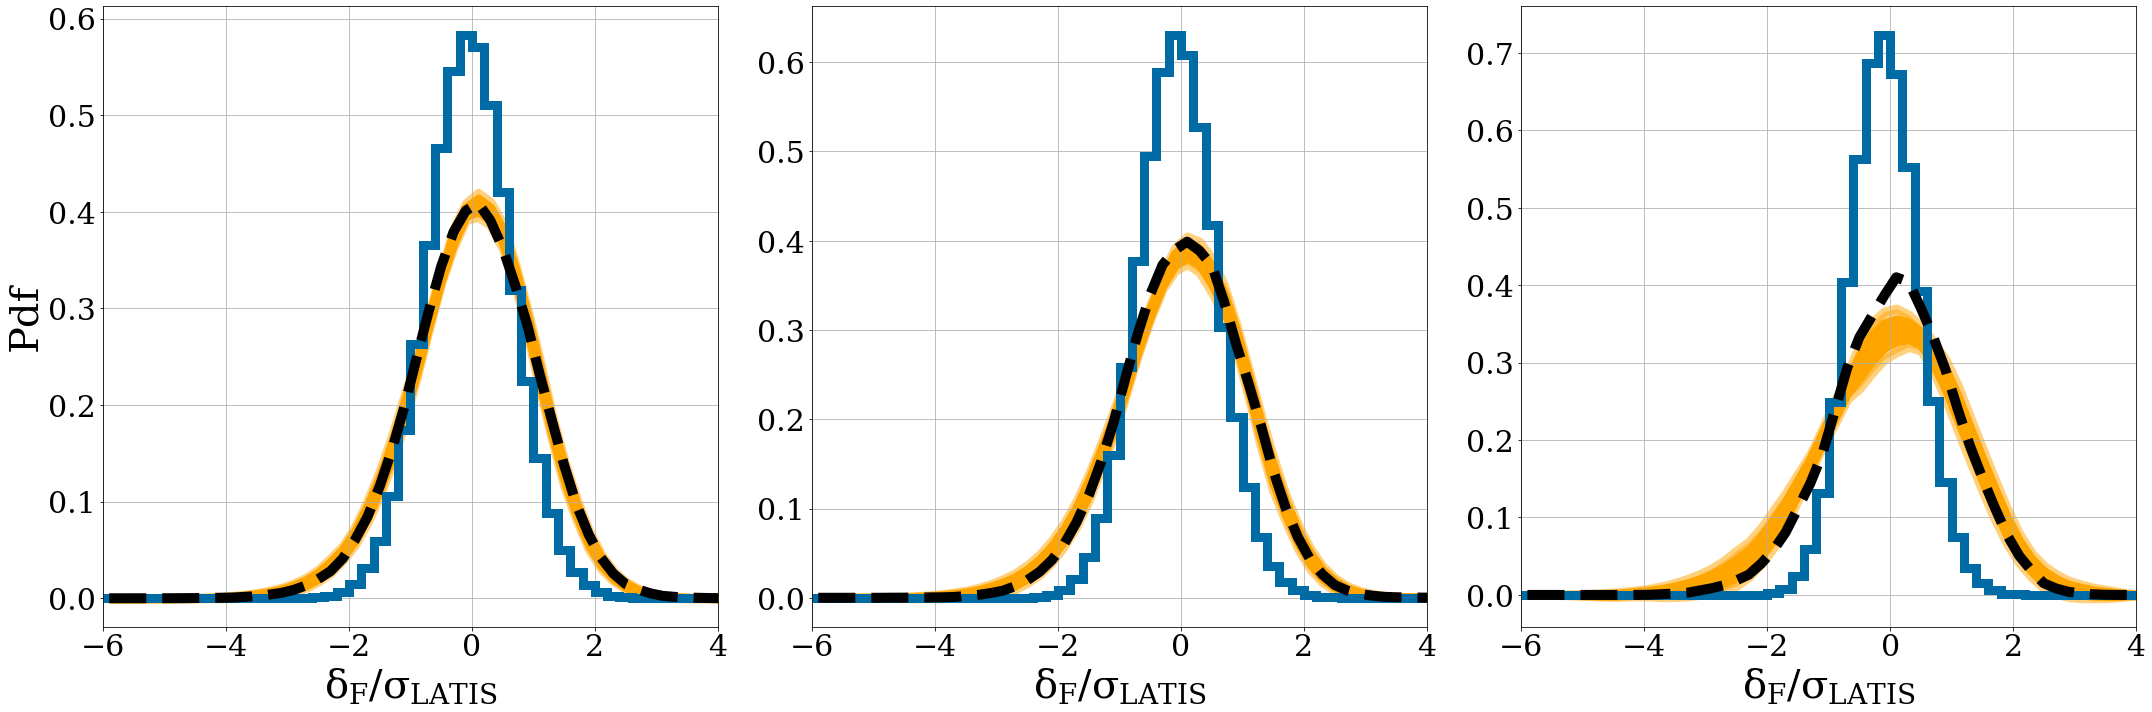

In [52]:
compare_with_pure_noise(z=2.3, z_range=[2.2,2.4])

LATIS mean deltaF  at z=[2.2, 2.4] is  0.002944165263101341
Sigma =  1  ratio =  [937.31810146 923.53401173 578.93176855 372.17042264 286.70906633
 130.94885241 137.84089727 107.64717692]  at : [-3.525 -3.475 -3.425 -3.375 -3.325 -3.275 -3.225 -3.125]
LATIS mean deltaF  at z=[2.2, 2.4] is  0.003012623935547442
Sigma =  2  ratio =  [1240.56807546  799.47720418 1612.73849809  399.73860209  416.27950976
  402.03595038  230.57022817  131.57540194  113.71874025  103.78608736
  130.94885241   90.39181917]  at : [-3.325 -3.275 -3.225 -3.175 -3.125 -3.075 -3.025 -2.975 -2.925 -2.875
 -2.825 -2.775]
LATIS mean deltaF  at z=[2.2, 2.4] is  0.0029782073338613297
Sigma =  4  ratio =  [1362.32753471  247.73072371  165.16725059]  at : [-2.475 -2.425 -2.375]


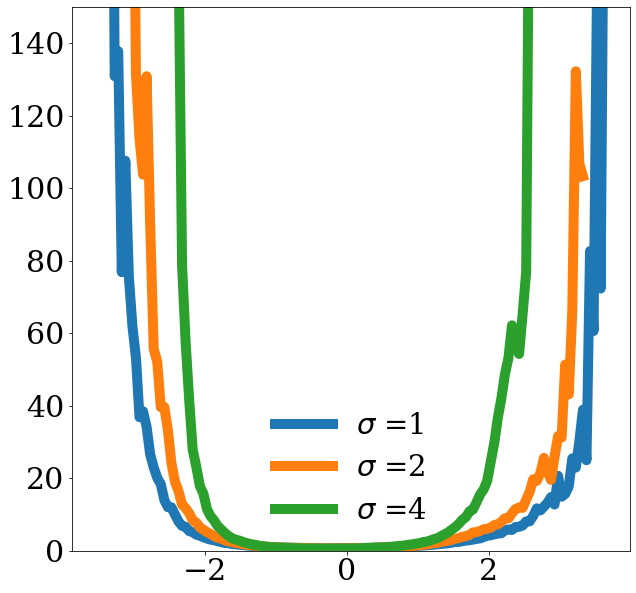

In [23]:
get_ratio_hists(z=2.3, z_range=[2.2,2.4])

LATIS mean deltaF  at z=[2.5, 2.7] is  0.00486755870071259
LATIS mean deltaF  at z=[2.5, 2.7] is  0.004759823846725938
LATIS mean deltaF  at z=[2.5, 2.7] is  0.004591122027035725
LATIS mean deltaF  at z=[2.2, 2.8] is  0.0014317872940299533
LATIS mean deltaF  at z=[2.2, 2.8] is  0.0013913208566972387
LATIS mean deltaF  at z=[2.2, 2.8] is  0.0013314368584052604


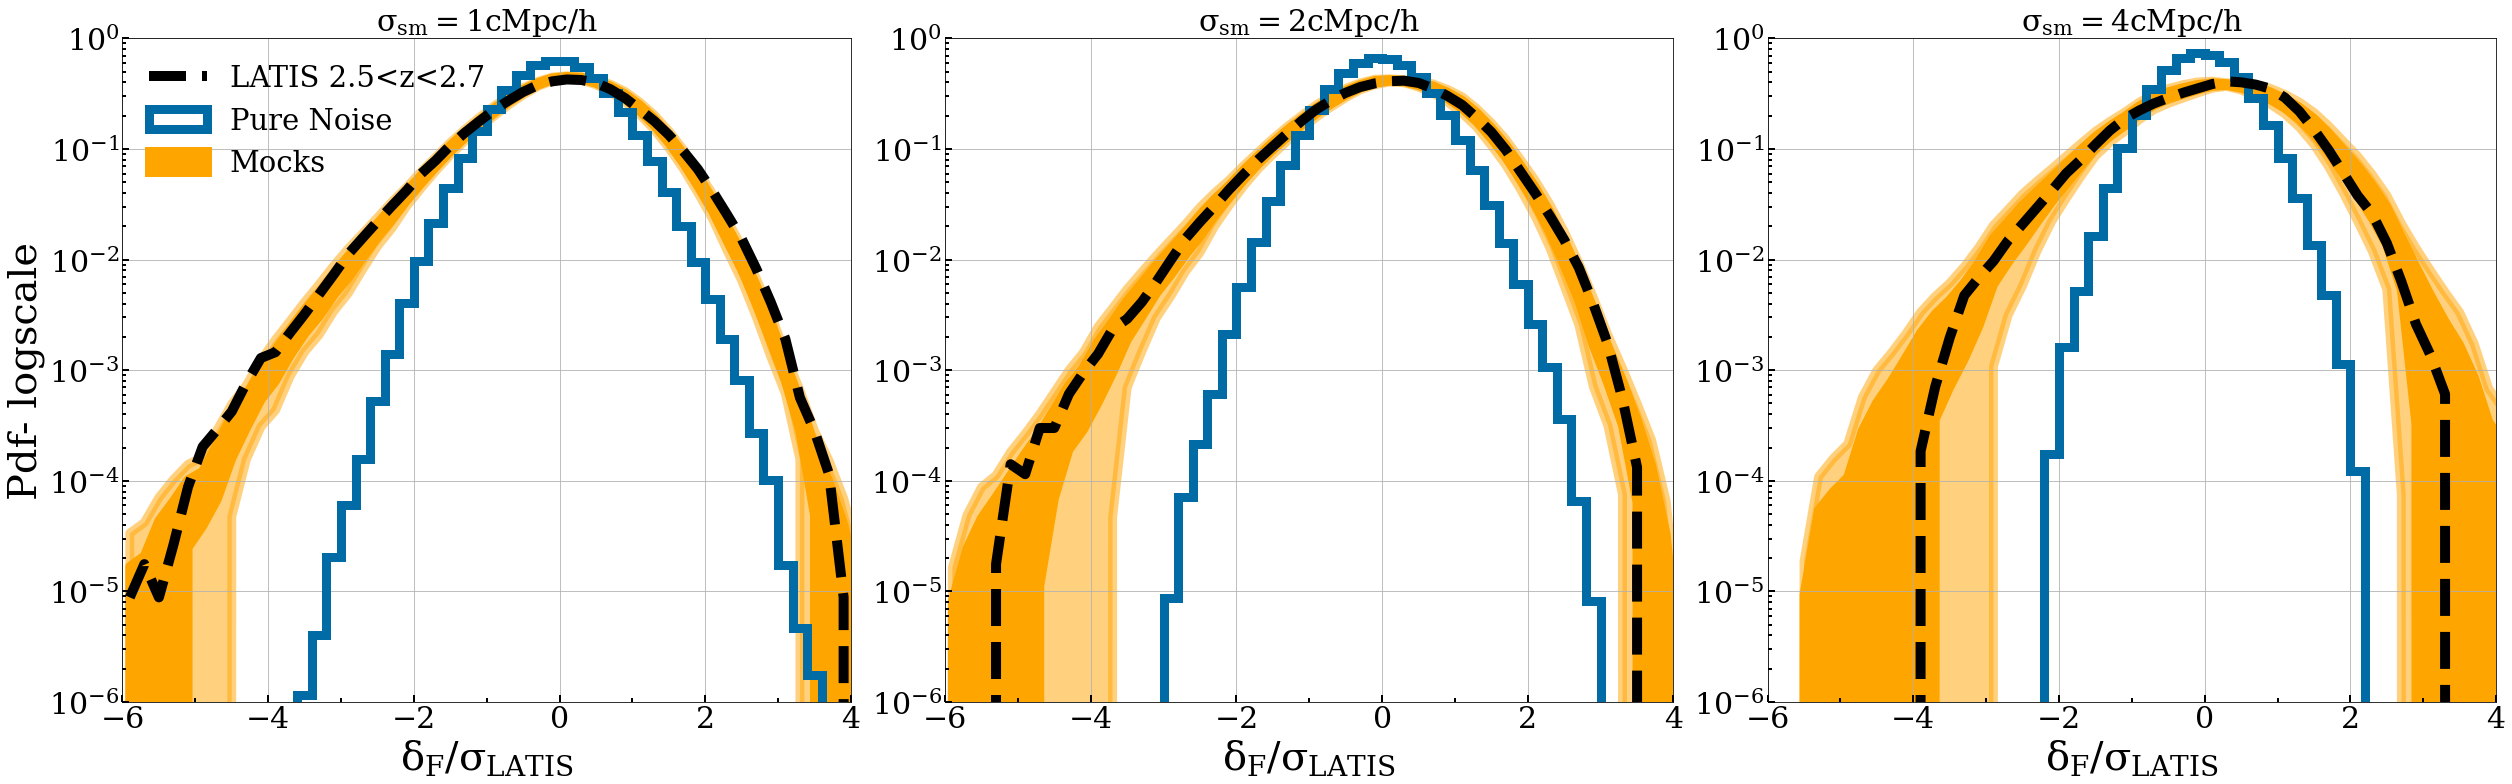

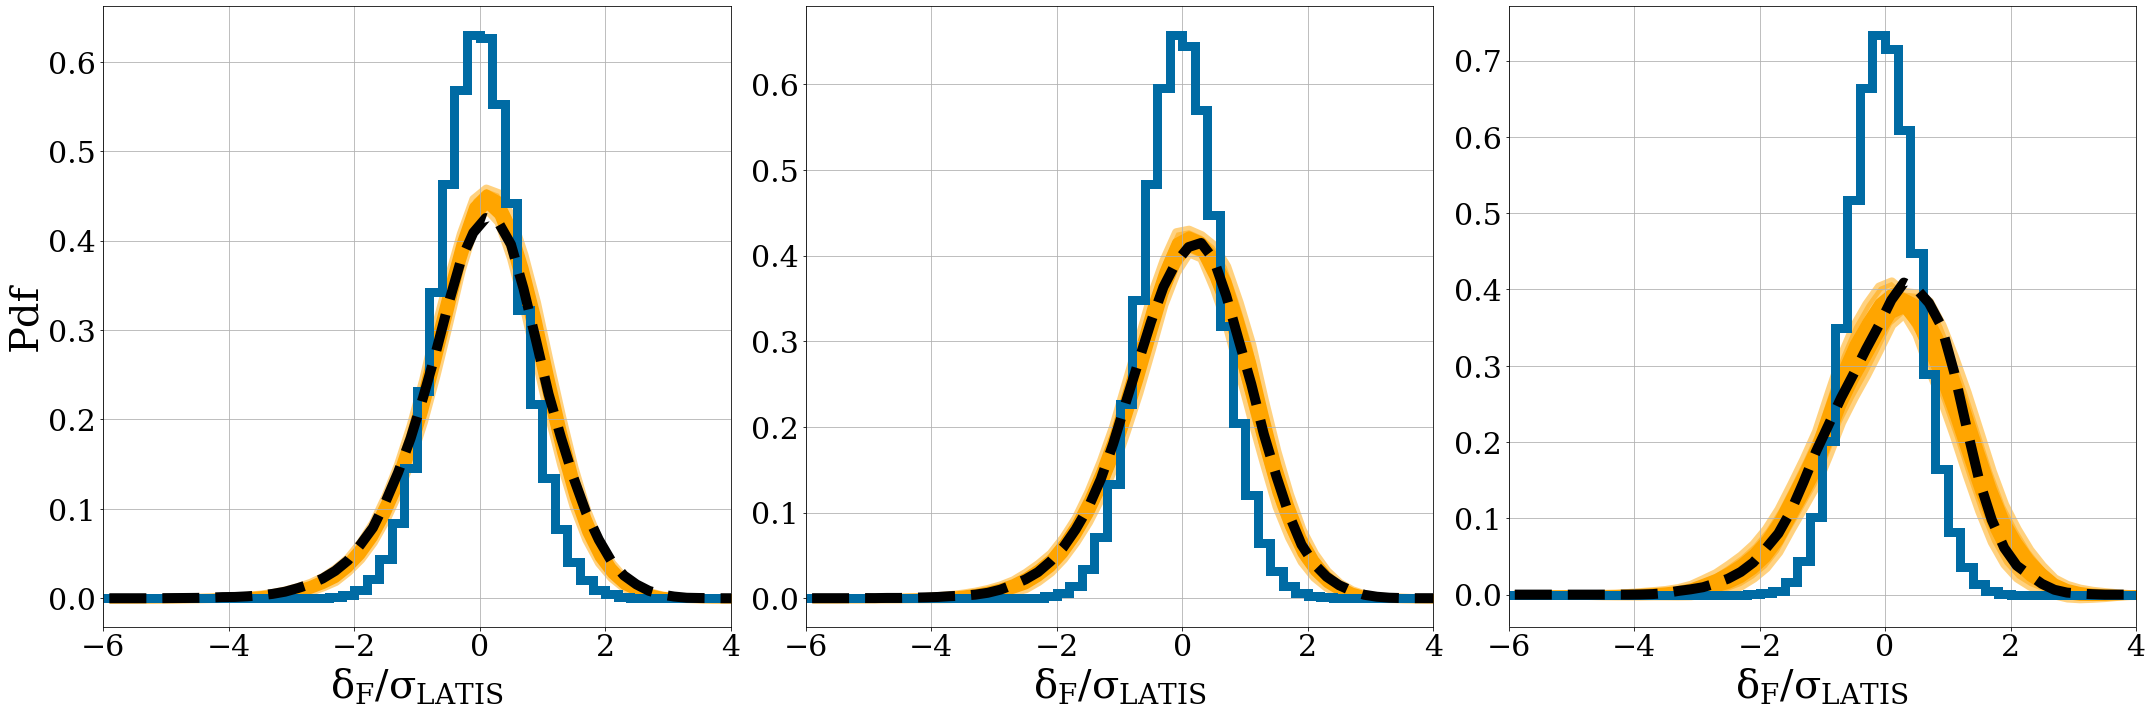

In [63]:
compare_with_pure_noise(z=2.6, z_range=[2.5,2.7])

LATIS mean deltaF  at z=[2.5, 2.7] is  0.00486755870071259
Sigma =  1  ratio =  [1087.29789065 1437.05805128 1323.00582499  739.05842637  425.79497816
  694.45133342  780.62412662  248.38040392  278.5275421   243.94503957
  155.52576313  228.56526966   98.30980632  119.6129816    90.33839706]  at : [-3.275 -3.175 -3.125 -3.075 -3.025 -2.975 -2.925 -2.875 -2.825 -2.775
 -2.725 -2.675 -2.625 -2.575 -2.525]
LATIS mean deltaF  at z=[2.5, 2.7] is  0.004759823846725938
Sigma =  2  ratio =  [5139.95366489 2843.70217554  912.41781033  568.9938845   407.38654865
  245.68750414  229.62514893  128.05864005  161.68580315  124.82382544
   90.90132663]  at : [-2.825 -2.775 -2.725 -2.675 -2.625 -2.575 -2.525 -2.475 -2.425 -2.375
 -2.325]
LATIS mean deltaF  at z=[2.5, 2.7] is  0.004591122027035725
Sigma =  4  ratio =  [18947.87652796  1597.90093451   378.36987163   143.39272058
    88.56106631]  at : [-2.075 -2.025 -1.975 -1.925 -1.875]


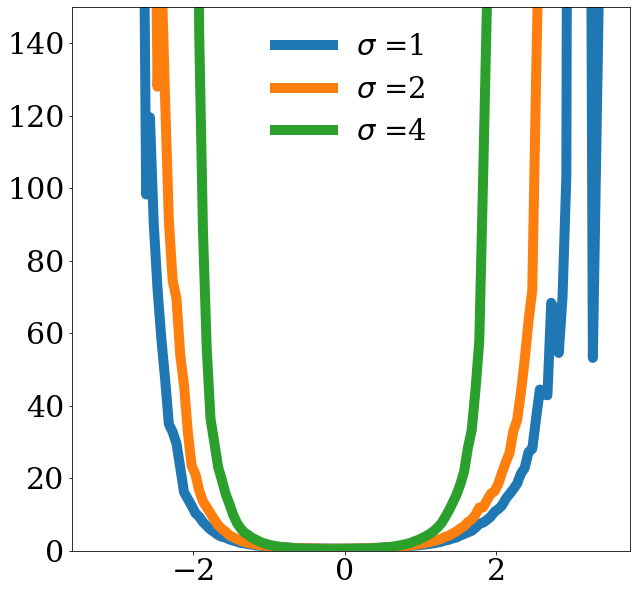

In [22]:
get_ratio_hists(z=2.6, z_range=[2.5,2.7])

So the best $\nu$s are -2.4 and -1.9 for z=2.3 and z=2.6 

In [73]:
z1 = sm.get_mock_sightline_number(z_range=[2.2,2.4])
z2 = sm.get_mock_sightline_number(z_range=[2.4,2.6])
z3 = sm.get_mock_sightline_number(z_range=[2.5,2.7])
print('Sghtline number in mock spectra =', z1, 'ratio=', z1/z2)
print('Sghtline number in mock spectra =', z2, 'ratio=', 1)
print('Sghtline number in mock spectra =', z3, 'ratio=', z3/z2)

Sghtline number in mock spectra = 9081.55769242037 ratio= 1.3476972872506516
Sghtline number in mock spectra = 6738.573846169163 ratio= 1
Sghtline number in mock spectra = 5181.581745713757 ratio= 0.7689433794154314


The goal is to show if the M0-Mtomo and MDM-Mtomo change for these new maps.

## Halo Mass function and $\nu$ :

# Choosing $\kappa$ :

1. Get Error on Mtomo for different mock realizations. I used the MPI code `get_err_Mtomo_th_more.py`.

For z=2.4:

In [2]:
def plot_err_Mtomo(ax, th, mean, std, kappa_best = -2.35, label='z=2.4'):
    plt.style.use('./Notebook.mystyle')
    ax.grid(True)
    ax.plot(th, mean)
    #ax.fill_between(th, mean-std, mean+std, color='C3', alpha=0.4, edgecolor='None')
    ax.errorbar(th, mean, std, label=label, alpha=0.4)
    ax.plot([-3.2,-2.0], [0.48, 0.48], ls='--')
    ind = np.where((mean < 0.5)*(mean > 0.48))
    print(th[ind], mean[ind])
    
    #ax.set_xlim((np.min(th), np.max(th)))
    ax.set_ylim((0.2,1.0))
    ax.set_xlabel(r'$\mathrm{ \kappa }$', fontsize=38)
    ax.set_ylabel(r'$\rm error \ in \ M_{tomo, raw} $', fontsize=38)


[-2.3  -2.35] [0.49318441 0.4868637 ]


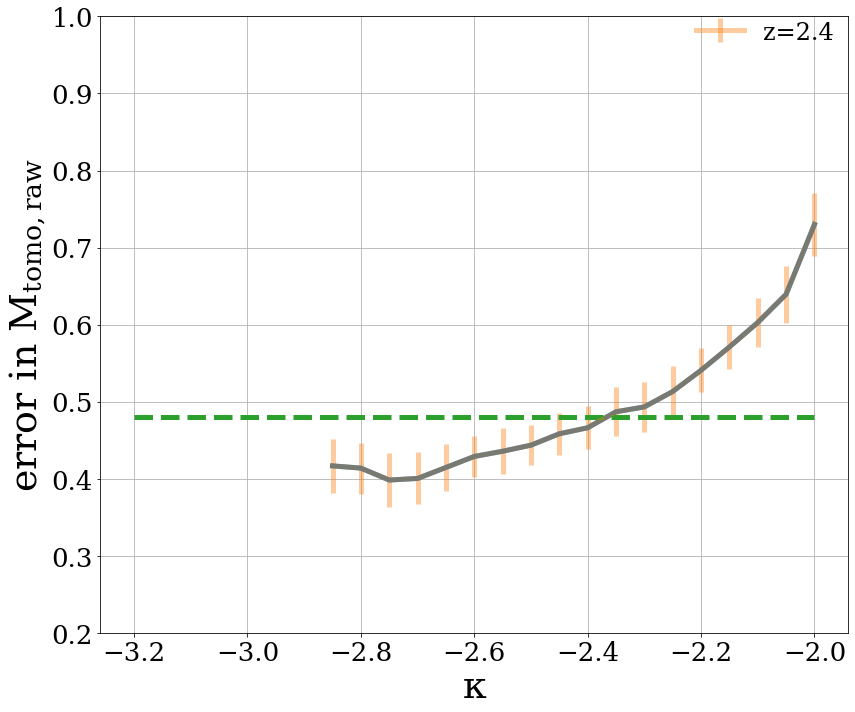

In [4]:
fig, ax = plt.subplots(1,1, figsize=(12,10))
#lc = [2.35,2.0,1.90]
lc = [2.0]
for i, z in enumerate([2.4]):
    with h5py.File('./thresh/error_Mtomo_mocks_z'+str(z)+'_sigma4.hdf5','r') as f:
        th = -1*np.arange(lc[i],lc[i]+0.9, 0.05)
        nrange = np.arange(1,20,1)
        mean = np.mean(f['Mtomo_err'][0::,:], axis=0)
        std =  np.std(f['Mtomo_err'][0::,:], axis=0)
        plot_err_Mtomo(ax, th, mean, std, lc[i], label='z='+str(z))
fig.legend()
plt.tight_layout()
#plt.savefig('err_Mtomo_thresh.pdf')

Now fixing the $\kappa$ for $\sigma_{sm} = 2$ at z=2.45.

(20, 18)
[-2.3  -2.35] [0.49310466 0.48679074]
(20, 18)
[-2.75] [0.48832268]


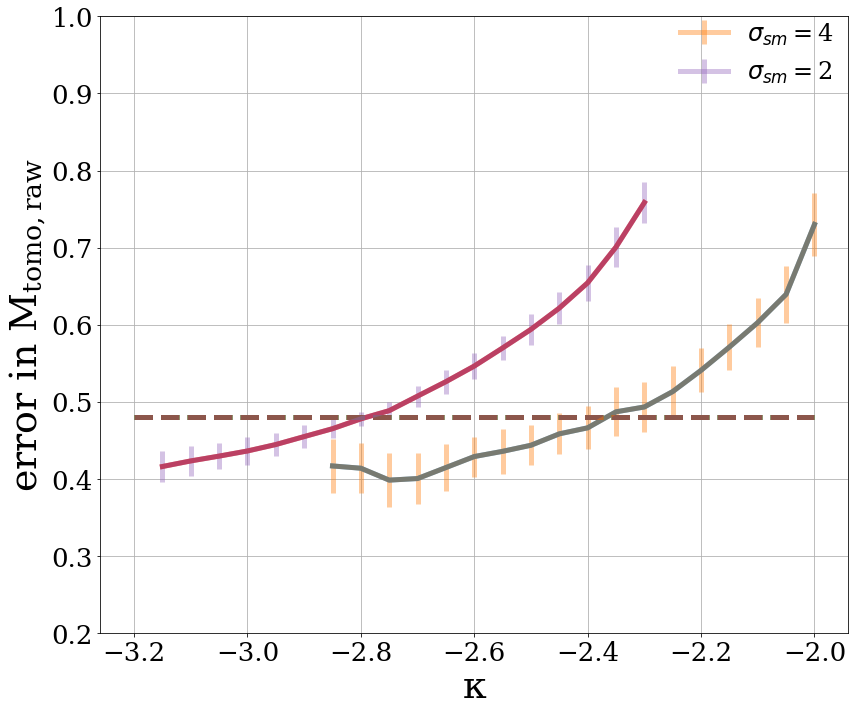

In [40]:
fig, ax = plt.subplots(1,1, figsize=(12,10))
lc = [2.00,2.35]
th_all = [-1*np.arange(2,2.9, 0.05), -1*np.arange(2.3,3.19, 0.05)]
for i, sigma in enumerate([4,2]):
    with h5py.File('./thresh/error_Mtomo_mocks_z2.4_sigma'+str(sigma)+'.hdf5','r') as f:
        print(f['Mtomo_err'][:].shape)
        th = th_all[i]
        nrange = np.arange(1,20,1)
        mean = np.mean(f['Mtomo_err'][0::,:], axis=0)
        std =  np.std(f['Mtomo_err'][0::,:], axis=0)
        plot_err_Mtomo(ax, th, mean, std, label=r'$\sigma_{sm}=$'+str(sigma))
fig.legend()
plt.tight_layout()
#plt.savefig('err_Mtomo_thresh.pdf')

So, the selected parametrs are :

| z  | $\nu$ | $\kappa$ |
|----|---|---|
|2.3 | -2.35 | -2.75 |
|2.45 | -2.0 | -2.35 |
|2.45 sigma=2 | -2.30 |-2.75 |
|2.6  | -1.90 |  -2.4|





In [3]:
def test():
    for z in [2.3,2.4,2.6]:
        print(h5py.File('./spectra/spectra_TNG_z'+str(z)+'_n1.hdf5','r')['Header'].attrs['redshift'][()])
test()

2.3161107439568918
2.4442257045541464
2.5772902716018935


However, in `MDM_Mtomo.ipynb` and `M0_Mtomo.ipynb`, we show that there is no need to change $\nu$  nad $\kappa$ for different redshifts which is prefered for actual observations.